## MVG Gaussian Classifier

In [62]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn.datasets
def load_iris():
    D, L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L

In [3]:
D, L = load_iris()

In [4]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0) # 2/3 of the dataset D are used for training, 1/3 for validation
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1]) # take a random array of 150 elements, each element is 0<x<=149 (np.arange(150))
    idxTrain = idx[0:nTrain] # first 100 are indices of training samples 
    idxTest = idx[nTrain:] # remaining 50 are indices of validation samples
    DTR = D[:, idxTrain] # D for training
    DTE = D[:, idxTest] # D for validation
    LTR = L[idxTrain] # L for training
    LTE = L[idxTest] # L for validation
    return (DTR, LTR), (DTE, LTE)

In [5]:
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)

Now we have to compute the ML solution. First we compute the empirical mean and variance for each class label

The training phase consists in computing the empirical class mean and the empirical class covariance matrix given the training samples DTR. Here we're fitting a normal distribution to our training dataset

In [6]:
mu_classes = [] # list of empiracal mean for each class
cov_classes = [] # list of covariance matrix for each class
for i in set(LTR):
    DTR_class_i = DTR[:,LTR==i]
    N_class_i = DTR_class_i.shape[1]
    mu_class_i = DTR_class_i.mean(axis=1).reshape(-1,1)
    cov_class_i = 1/N_class_i * np.dot(DTR_class_i-mu_class_i, (DTR_class_i-mu_class_i).T)
    mu_classes.append(mu_class_i)
    cov_classes.append(cov_class_i)

The test phase consists in computing the normal density for each testing sample, thus the probability for each test sample to belong to either class 0 or 1 or 2.

In [7]:
def logpdf_GAU_ND_1sample(x,mu,C):
    M = x.shape[0] # num of features of sample x
    mu = mu.reshape(M,1) # mean of the sample
    xc = x - mu # x centered
    invC = np.linalg.inv(C)
    _,log_abs_detC = np.linalg.slogdet(C)
    return -M/2 * np.log(2*np.pi) - 1/2 * log_abs_detC - 1/2 * np.dot(np.dot(xc.T,invC),xc)

In [8]:
S = np.zeros(shape=(3,DTE.shape[1]))
for i in range(DTE.shape[1]):
    xt = DTE[:,i:i+1] # test sample xt
    # now compute the probability density related to each class label for the sample xt
    score = np.zeros(shape=(3,1))
    for j in set(LTE):
        mu = mu_classes[j]
        C = cov_classes[j]
        score[j,:] = np.exp(logpdf_GAU_ND_1sample(xt,mu,C))
    S[:,i:i+1] = score

In [9]:
SJoint = 1/3 * S # assuming that the prior probability is 1/3 for each class
SJoint_sol = np.load('Solution/SJoint_MVG.npy')
print(np.abs(SJoint_sol - SJoint).max()) # test if it's correct

6.661338147750939e-15


In [20]:
SMarginal = SJoint.sum(0).reshape(-1,1)

In [32]:
SPost = np.zeros((3,50))
for c in range(3):
    SJoint_c = SJoint[c,:].reshape(-1,1)
    SPost_c = (SJoint_c / SMarginal).reshape(1,-1)
    SPost[c,:] = SPost_c

In [57]:
predicted_labels = np.argmax(SPost,axis=0)
corrected_assigned_labels = LTE==predicted_labels
acc = sum(corrected_assigned_labels) / len(LTE)
err = 1-acc
print('Error rate %f%%' % (err * 100))

Error rate 4.000000%


Using logarithms calculus to avoid numerical issues:

In [72]:
logSJoint = np.log(SJoint) + np.log(1/3)
logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1,-1)
log_SPost = logSJoint - logSMarginal  
SPost_ = np.exp(log_SPost)

Decision boundaries(extra)

In [83]:
DTE_1 = DTE[:, LTE==1]
mu_1 = np.mean(DTE_1,axis=1).reshape(-1,1)
DTE_1_centered = DTE_1 - mu_1
N1 = np.shape(DTE_1)[1]
C1 = 1/N1 * np.dot(DTE_1_centered, DTE_1_centered.T)

array([[0.25086505, 0.06955017, 0.17238754, 0.06294118],
       [0.06955017, 0.07653979, 0.06442907, 0.03588235],
       [0.17238754, 0.06442907, 0.20934256, 0.08764706],
       [0.06294118, 0.03588235, 0.08764706, 0.04941176]])

In [85]:
DTE_0 = DTE[:, LTE==0]
mu_0 = np.mean(DTE_0,axis=1).reshape(-1,1)
DTE_0_centered = DTE_0 - mu_1
N0 = np.shape(DTE_0)[1]
C0 = 1/N0 * np.dot(DTE_0_centered, DTE_0_centered.T)
C0

array([[ 0.91359315, -0.54840466,  2.50507376,  0.96343653],
       [-0.54840466,  0.57451284, -1.90285012, -0.71907121],
       [ 2.50507376, -1.90285012,  7.7332271 ,  2.9452322 ],
       [ 0.96343653, -0.71907121,  2.9452322 ,  1.13      ]])

In [121]:
V0 = C0**-1
V1 = C1**-1
A = -1/2*(V1-V0)
b = np.dot(V1,mu_1) - np.dot(V0,mu_0)
_,logabsV1 = np.linalg.slogdet(V1)
_,logabsV0 = np.linalg.slogdet(V0)
c = -1/2 * (np.dot(np.dot(mu_1.T,V1),mu_1) - np.dot(np.dot(mu_0.T,V0),mu_0)) + 1/2 * (logabsV1-logabsV0)

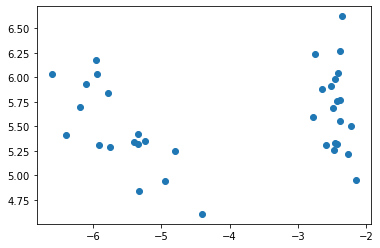

In [170]:
#apply PCA
l = np.logical_or((LTE==0),(LTE==1))
DTE10 = DTE[:,l]
P = projection_PCA(DTE10, 2)
y = np.dot(P.T, DTE10)

#plot decision function
def llr(xt):
    return np.dot(np.dot(xt.T,A),xt) + np.dot(xt.T,b) + c
xt = np.arange(-10
plt.scatter(y[0,:],y[1,:])

In [154]:
def projection_PCA(X,m):
    mu = D.mean(axis = 1).reshape(-1,1)
    Xc = X - mu
    K = np.shape(X)[1] # number of columns of X
    C = 1/K * np.dot(Xc, Xc.T) # covariance matrix
    sigma, U = np.linalg.eigh(C)
    P = U[:, ::-1][:, 0:m] # take the m eigenvectos of C associated to the m highest eigenvalues
    return P